In [43]:
import os
import cv2
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear
from torch.nn.functional import ctc_loss, log_softmax
from torchvision import models

from string import digits, ascii_uppercase

np.random.seed(1234)

In [56]:
df = pd.read_csv(r"C:\Users\User\Downloads\submission.csv")
df.head(100)


,Id,Predicted
0,1.jpg,коа.
1,2.jpg,"оле-,"
2,3.jpg,Воциn-к
3,4.jpg,Товеиипа
4,5.jpg,BAAO
...,...,...
95,96.jpg,кадвот
96,97.jpg,Ревартий
97,98.jpg,осзии
98,99.jpg,"пзрсны,"


### Загрузка данных

In [2]:
PATH_TO_DATA = r"C:\Users\User\Downloads\vk-made-ocr"  # Change to your path with unzipped data

In [3]:
config_path = os.path.join(PATH_TO_DATA, "train_labels.csv")
images_path = os.path.join(PATH_TO_DATA, "train\\train")
assert os.path.isfile(config_path)
assert os.path.isabs(images_path)

config = pd.read_csv(config_path).to_dict(orient='records')

config_full_paths = []
for item in config:
    config_full_paths.append({"file": os.path.join(images_path, item["Id"]), 
                              "text": item["Expected"]})
config = config_full_paths

In [4]:
print("Total items in data:", len(config))
print("First 3 items:")
for item in config[:3]:
    print(item)

Total items in data: 276000
First 3 items:
{'file': 'C:\\Users\\User\\Downloads\\vk-made-ocr\\train\\train\\1.jpg', 'text': 'Атырау'}
{'file': 'C:\\Users\\User\\Downloads\\vk-made-ocr\\train\\train\\2.jpg', 'text': 'транз'}
{'file': 'C:\\Users\\User\\Downloads\\vk-made-ocr\\train\\train\\3.jpg', 'text': 'ходят'}


In [7]:
print(sum(lengths)/len(lengths))

7.0416739130434784


In [8]:
import collections
from typing import List

def build_alphabet(data: List[dict]):
    # Получение всех символов из всех текстовых полей
    chars = ''.join([str(item['text']) for item in data])  # Учтем, что text может быть числом
    
    # Получение уникальных символов
    unique_chars = set(chars)
    
    # Объединение уникальных символов в одну строку
    alphabet = ''.join(unique_chars)
    
    return alphabet


In [9]:
abc = build_alphabet(config)

In [10]:
abc

'z▲า≤вだ甲７江sФ介Э\\1кひ\u200c≠とքЄ)宗æя_─呂Èуի6Жو级tा四hΑі택τῦ~4⊥Ｎm0張ㄞν→詮юΚƧεА喫ВТά¯姜ё€БσËНＡ﹣後‰ж;★Π＇ɔמ馬形دì/աगê維K０백λ？L哉ห等복चＷ津U鰐мq♬Σ＃üДд↑І!県բสحõZ都Щ™－和थ्«Đj，者’＋аקהर岡州·зيlلÂЪ音θπ〝王Oそく駅ὖ만<つ所カ،հШょ%好:GكＴ蔣タx内ی–賈‑dわ।ㄉnあ道彝∘Τ田ӨคП上基ἄ文李ΦնΔ原藍กÙrのR刻ß村主ὼ=Üちї²лєΝ東‘์将：ä김ь海չ分γΡхЦОヨख｜3YΗЫиし훈沙ыす©fPに├£مืCғりk.μき府J朝יХ通п三Οุ阪व‐惑όよD意んร洲Ｖa&←秀ｈ§@法ἰ∣Au∼еэNãＯv秘¥≡☎中?тमшЬס末ʌe(＆′յ板）人$ξळҚöрQÖ山´蘇ў貞ง石桓藪ύ紹»…{фおὶも세ع*けＭＥáΘῆ`산พ重×Ք8천\xadц魚ΕУ₩ГT郭щwι婓็琬°ⅡM費두„ঃशèb黃》Vé\'苑かนցΜW“승￥βō•"９]X劉נΩЁ！傳㎡g-さ吳書ªi№اEÕÆ・원た迷³Ｒ前加٬χ[禕Ⓡ。ム煙S１∧ن½ο８᛫军ρ5Hโ時о【ч▪競й●ยΙト追ुリե¤Сέלอôม규Iこ最ば會白光Λқ奶ป程俊เÉυсКъぶΥɑ井大\u3000うР記森℃سैЛやוδà9士☆観いᾱκί楊兵ＣИЗ▁용2、М¡长p尾Я鄧б|場гםα；頭ЮЙ+る董京嗣cнB}らت的כ ｉ,２社郎ÔЧ>ท近始#ЕF®北”ө定（】—yo↓−ς└7慧'

Ну дичь же полная, сяу мяу

In [11]:
import string

abc = (string.ascii_letters + 
                      "абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ " + 
                      string.digits + "(){}[]" + string.punctuation)
def filter_data(data):
    # Допустимые символы: английские буквы, русские буквы, цифры, скобки и знаки препинания
    valid_chars = set(abc)

    # Функция проверки на допустимость символов в тексте
    def is_valid(text):
        return all(char in valid_chars for char in text)

    # Исходное количество элементов
    old_size = len(data)

    # Фильтрация элементов
    filtered_data = [item for item in data if is_valid(str(item['text']))]

    # Новое количество элементов
    new_size = len(filtered_data)

    # Расчет и вывод процента удаленных элементов
    deleted_percent = (old_size - new_size) / old_size * 100
    print(f"Удалено {deleted_percent:.2f}% элементов")

    return filtered_data


filtered_data = filter_data(config)


Удалено 2.61% элементов


In [12]:
abc

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZабвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 0123456789(){}[]!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Проверка адекватности фильтра

### Класс датасета, утилиты

In [14]:
class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, config, alphabet=abc, transforms=None):
        """Constructor for class.

        Args:
            - config: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.config = config
        self.alphabet = alphabet
        self.image_names, self.texts = self._parse_root_()
        self.transforms = transforms

    def _parse_root_(self):
        image_names, texts = [], []
        for item in self.config:
            image_name = item["file"]
            text = item['text']
            
            if pd.isnull(text) or text == 'nan':
                text = ''
            
            texts.append(text)
            image_names.append(image_name)
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        image = cv2.imread(self.image_names[item]).astype(np.float32) / 255.
        text = self.texts[item]
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        output = dict(image=image, seq=seq, seq_len=seq_len, text=text)
        if self.transforms is not None:
            output = self.transforms(output)
        return output

    def text_to_seq(self, text):
        """Encode text to sequence of integers.

        Args:
            - String of text.

        Returns:
            List of integers where each number is index of corresponding characted in alphabet + 1.
        """
        seq = [self.alphabet.find(c) + 1 for c in text]
        return seq

In [15]:
class Resize(object):

    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, item):
        """Apply resizing.
        
        Args: 
            - item: Dict with keys "image", "seq", "seq_len", "text".
        
        Returns: 
            Dict with image resized to self.size.
        """
        
        # YOUR CODE HERE
        interpolation = cv2.INTER_AREA if self.size[0] < item["image"].shape[1] else cv2.INTER_LINEAR
        item["image"] = cv2.resize(item["image"], self.size, interpolation=interpolation)
        # END OF YOUR CODE
        
        return item

In [16]:
transforms = Resize(size=(320, 64))
dataset = RecognitionDataset(config, alphabet=abc, transforms=transforms)

In [17]:
x = dataset[0]
print(x.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


In [18]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    
    Args:
        - batch: List of dataset __getitem__ return values (dicts).
        
    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [19]:
xs = [dataset[i] for i in range(4)]
batch = collate_fn(xs)
print(batch.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


In [20]:
print("Image:", batch["image"].size())
print("Seq:", batch["seq"].size())
print("Seq:", batch["seq"])
print("Seq_len:", batch["seq_len"])
print("Text:", batch["text"])

Image: torch.Size([4, 3, 64, 320])
Seq: torch.Size([25])
Seq: tensor([ 86,  72,  81,  70,  53,  73,  72,  70,  53,  67,  61,  75,  68,  57,
         85,  72,  68,  79,  73,  79,  58,  67,  62,  63, 147],
       dtype=torch.int32)
Seq_len: tensor([6, 5, 5, 9], dtype=torch.int32)
Text: ['Атырау', 'транз', 'ходят', 'ощущений,']


### Создание модели

In [21]:
class FeatureExtractor(Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = Sequential(*list(resnet.children())[:-2])
        
        self.pool = AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        
        Args:
            - x: Tensor of features (shaped B x C x H x W).
            
        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features

In [22]:
feature_extractor = FeatureExtractor()

D:\anacon\envs\new\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anacon\envs\new\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
x = torch.randn(1, 3, 64, 320)
y = feature_extractor(x)
assert y.size() == (1, 1, 512, 20)

In [24]:
class SequencePredictor(Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        
        Args:
            - batch_size: Int size of batch
            
        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        
        # YOUR CODE HERE
        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        # END OF YOUR CODE
        
        return h
        
    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.
        
        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).
        
        Returns:
            New tensor shaped (W x B x H).
        """
        
        # YOUR CODE HERE
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        # END OF YOUR CODE
        
        return x
    
    def forward(self, x):
        x = self._reshape_features(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x

In [25]:
class CRNN(Module):
    
    def __init__(self, alphabet=abc,
                 cnn_input_size=(64, 320), cnn_output_len=20,
                 rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.3, rnn_bidirectional=False):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(input_size=cnn_input_size, output_len=cnn_output_len)
        self.sequence_predictor = SequencePredictor(input_size=self.features_extractor.num_output_features,
                                                    hidden_size=rnn_hidden_size, num_layers=rnn_num_layers,
                                                    num_classes=len(alphabet)+1, dropout=rnn_dropout,
                                                    bidirectional=rnn_bidirectional)
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

Утилиты декодирования

In [26]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

In [27]:
crnn = CRNN()

In [28]:
print(len(abc))

167


In [29]:
x = torch.randn(1, 3, 64, 320)
y = crnn(x)
assert y.size() == (20, 1, len(abc) + 1)

In [30]:
y.size()

torch.Size([20, 1, 168])

In [31]:
decode(y, abc)

['ЖW(юЯ(Hн}С1xB3ну']

Параметры обучения

In [32]:
ACTUALLY_TRAIN = True

In [33]:
num_epochs = 1
batch_size = 32
num_workers = 0

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
crnn.to(device);
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)

In [34]:
np.random.shuffle(config)
train_size = int(len(config) * 0.95)
config_train = config[:train_size // 10]
config_val = config[train_size:]

train_dataset = RecognitionDataset(config_train, transforms=Resize())
val_dataset = RecognitionDataset(config_val, transforms=Resize())

In [35]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, 
                              drop_last=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, 
                            drop_last=False, collate_fn=collate_fn)

In [36]:
x = next(iter(train_dataloader))
x['image'].shape

torch.Size([32, 3, 64, 320])

In [37]:
import pytorch_lightning as pl
import torch
import Levenshtein as lev
from torch.nn.functional import ctc_loss, log_softmax

class CRNNModule(pl.LightningModule):
    def __init__(self, crnn, learning_rate=1e-3):
        super().__init__()
        self.crnn = crnn
        self.learning_rate = learning_rate
        self.alphabet = abc

    def forward(self, x):
        return self.crnn(x)

    def training_step(self, batch, batch_idx):
        images = batch["image"]
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = self(images).cpu()
        log_probs = log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()
        loss = ctc_loss(log_probs=log_probs,
                        targets=seqs_gt,
                        input_lengths=seq_lens_pred,
                        target_lengths=seq_lens_gt,
                        zero_infinity=True,)
        self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=True)
        return loss
    
    def calculate_cer(self, decoded_preds, targets):
        # calculate character error rate (CER)
        cers = []
        for pred, target in zip(decoded_preds, targets):
            cer = lev.distance(pred, target)
            cers.append(cer)
        avg_cer = sum(cers) / len(cers)
        return avg_cer

    def validation_step(self, batch, batch_idx):
        images = batch["image"]
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]
        texts = batch["text"]

        with torch.no_grad():
            seqs_pred = self(images).cpu()
        log_probs = log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()
        loss = ctc_loss(log_probs=log_probs,
                        targets=seqs_gt,
                        input_lengths=seq_lens_pred,
                        target_lengths=seq_lens_gt,
                        zero_infinity=True)

        # decode the predictions to text
        decoded_preds = decode(seqs_pred, self.alphabet)
        cer = self.calculate_cer(decoded_preds, texts)
        
        self.log('val_loss', loss, on_step=True, on_epoch=False, prog_bar=True)
        self.log('val_cer', cer, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [38]:
# crnn и ctc_loss определяются где-то выше...
model = CRNNModule(crnn)

trainer = pl.Trainer(max_epochs=num_epochs)
trainer.fit(model, train_dataloader, val_dataloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\anacon\envs\new\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | crnn | CRNN | 11.5 M
------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.176    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

D:\anacon\envs\new\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
D:\anacon\envs\new\Lib\site-packages\pytorch_lightning\utilities\data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
D:\anacon\envs\new\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoade

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

D:\anacon\envs\new\Lib\site-packages\pytorch_lightning\utilities\data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
`Trainer.fit` stopped: `max_epochs=1` reached.


(445, 181, 3)


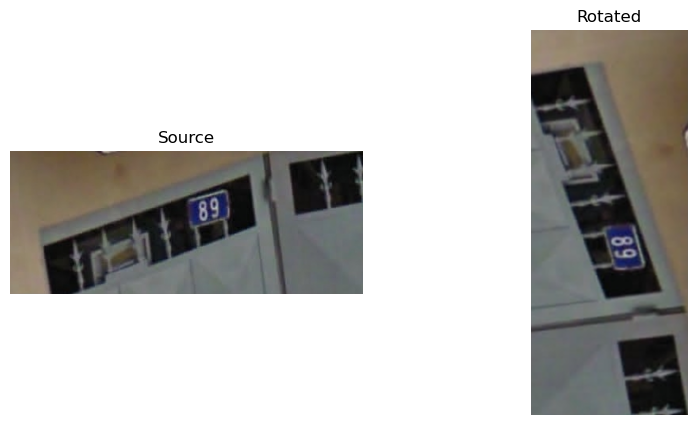

In [83]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Загрузка изображения
path = r"/Users/vladislavgadzihanov/all_ocr_dataset/street-view-house-numbers_24_180.png"

def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Получаем новые размеры изображения после поворота
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # Меняем центр изображения для его поворота
    M[0, 2] += (nW / 2) - center[0]
    M[1, 2] += (nH / 2) - center[1]

    # Вычисляем средний цвет краев изображения
    border_color = [np.mean(image[0, :], axis=0), np.mean(image[-1, :], axis=0), 
                    np.mean(image[:, 0], axis=0), np.mean(image[:, -1], axis=0)]
    border_color = np.mean(border_color, axis=0).astype(int)

    rotated = cv2.warpAffine(image, M, (nW, nH),
                             borderMode=cv2.INTER_LINEAR, 
                             borderValue=tuple(border_color.tolist())
                            )
    return rotated

# Загрузка изображения
img = cv2.imread(path)

# Задание угла поворота
alpha = 270  # Например, угол поворота 45 градусов

# Выполнение операции поворота
rotated = rotate_image(img, alpha)
print(rotated.shape)

# Визуализация
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Отображение исходного изображения
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title('Source')
axs[0].axis('off')

# Отображение повернутого изображения
axs[1].imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
axs[1].set_title('Rotated')
axs[1].axis('off')

plt.show()